<a href="https://colab.research.google.com/github/NicholasChoong/natural-language-processing/blob/main/lab_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Lab07

In this lab, we will learn how to implement attention mechanism in an RNN-based seq2seq model, the code is modified from [Official Doc of PyTorch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). The task we will focus on is question answering.


# 1. Download Dataset

The dataset we are using is the [chit-chat small talk datasets](https://github.com/microsoft/botframework-cli/blob/main/packages/qnamaker/docs/chit-chat-dataset.md). It provides the question-answer pairs for the ~100 scenarios, which are available for 5 pre-built personalities in 9 languages. In this example, we will use the English question-answer pairs of the chitchat personality.


In [15]:
import pandas as pd

df_friend = pd.read_csv("qna_chitchat_friendly.tsv", sep="\t")
df_friend.sample(10)

,Question,Answer,Source,Metadata
3457,I wish you had something else to say,My answers vary with different questions. Try ...,qna_chitchat_Friendly,editorial:chitchat
8688,I love comic con,I love that you love stuff!,qna_chitchat_Friendly,editorial:chitchat
2899,That is very intelligent,I have my moments.,qna_chitchat_Friendly,editorial:chitchat
7895,I'm just a cheerful person,I'm happy you're happy!,qna_chitchat_Friendly,editorial:chitchat
4931,I don't find that amusing,My lack of comedy is tragic.,qna_chitchat_Friendly,editorial:chitchat
894,Do you have any sisters?,I come from a long line of code.,qna_chitchat_Friendly,editorial:chitchat
7217,Do you know anything about my life?,"I don't know you, but I enjoy chatting with you!",qna_chitchat_Friendly,editorial:chitchat
7929,I am a jolly person,I'm happy you're happy!,qna_chitchat_Friendly,editorial:chitchat
3082,Are you currently going steady with anyone?,The only thing I'm committed to is being a gre...,qna_chitchat_Friendly,editorial:chitchat
467,Who's your manager?,I'm here for you!,qna_chitchat_Friendly,editorial:chitchat


In [16]:
# Get the number of data instances (Q-A pairs)
n_data = df_friend.shape[0]

# 2. Preprocessing

Let's do some simple preprocessing on the raw data.


In [17]:
# Get the question and answer list
question_list = df_friend["Question"].tolist()
answer_list = df_friend["Answer"].tolist()

# Have a look how they look like
print(question_list[:5])
print()
print(answer_list[:5])

["I'm so bored of you", "You're dull", 'That is not exciting', 'U basic', "You're boring"]

['Swing and a miss.', 'Swing and a miss.', 'Swing and a miss.', 'Swing and a miss.', 'Swing and a miss.']


In [18]:
import re
import nltk

nltk.download("punkt")

from nltk.tokenize import word_tokenize

# These are just common English contractions. We used it in Lab 5 before!
contraction_dict = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}


# We've practised all the preprocessing techniques below in Lab 5!
def pre_process(sent_list):
    output = []
    for sent in sent_list:
        sent = sent.lower()  # case-folding
        for word, new_word in contraction_dict.items():
            sent = sent.replace(word, new_word)  # dealing with contractions
        sent = re.sub(r"[^\w\s]", "", sent)  # removing punctuation
        output.append(word_tokenize(sent))  # tokenization
    return output


# Preprocessing the data using the function defined above
input_token_list = pre_process(question_list)  # -> input to encoder
answer_token_list = pre_process(answer_list)

# Adding special tokens for generation: <BOS> indicates beginning of sentence, <EOS> means end o sentence.
output_token_list = [
    ["<BOS>"] + s for s in answer_token_list
]  # -> input to decoder during the teacher-forcing training
target_token_list = [
    s + ["<EOS>"] for s in answer_token_list
]  # -> ground truth to be compared with the decoder output

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
# Here we simply use the maximum sentence length
MAX_LENGTH = max(
    [len(s) for s in input_token_list] + [len(s) for s in target_token_list]
)

In [20]:
# set up a vocab to index dictionary
word_to_ix = {"<BOS>": 0, "<EOS>": 1}
for sentence in input_token_list + output_token_list:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
word_list = list(word_to_ix.keys())

In [21]:
# construct token index lists for input, output and target
# i.e., to convert each sequence into corresponding index based on the index dictionary we created in the previous section
# e.g., ['are', 'your', 'systems', 'functioning'] -> [42, 6, 2576, 2577]
def to_index(data, to_ix):
    input_index_list = []
    for sent in data:
        input_index_list.append([to_ix[w] for w in sent])
    return input_index_list


input_index = to_index(input_token_list, word_to_ix)
output_index = to_index(output_token_list, word_to_ix)
target_index = to_index(target_token_list, word_to_ix)

# 3. Model


Now, we will implement the RNN-based seq2seq model with attention, more specifically, using the GRU. It consists of a GRU encoder and a GRU decoder, between which the attention mechanism is applied. We can refer to the architecture of Seq2Seq with Attention from Lecture 7 (From Page 29).

_If you are not familiar with attention and the seq2seq model, going through the lecture 7 recording would be really helpful!_


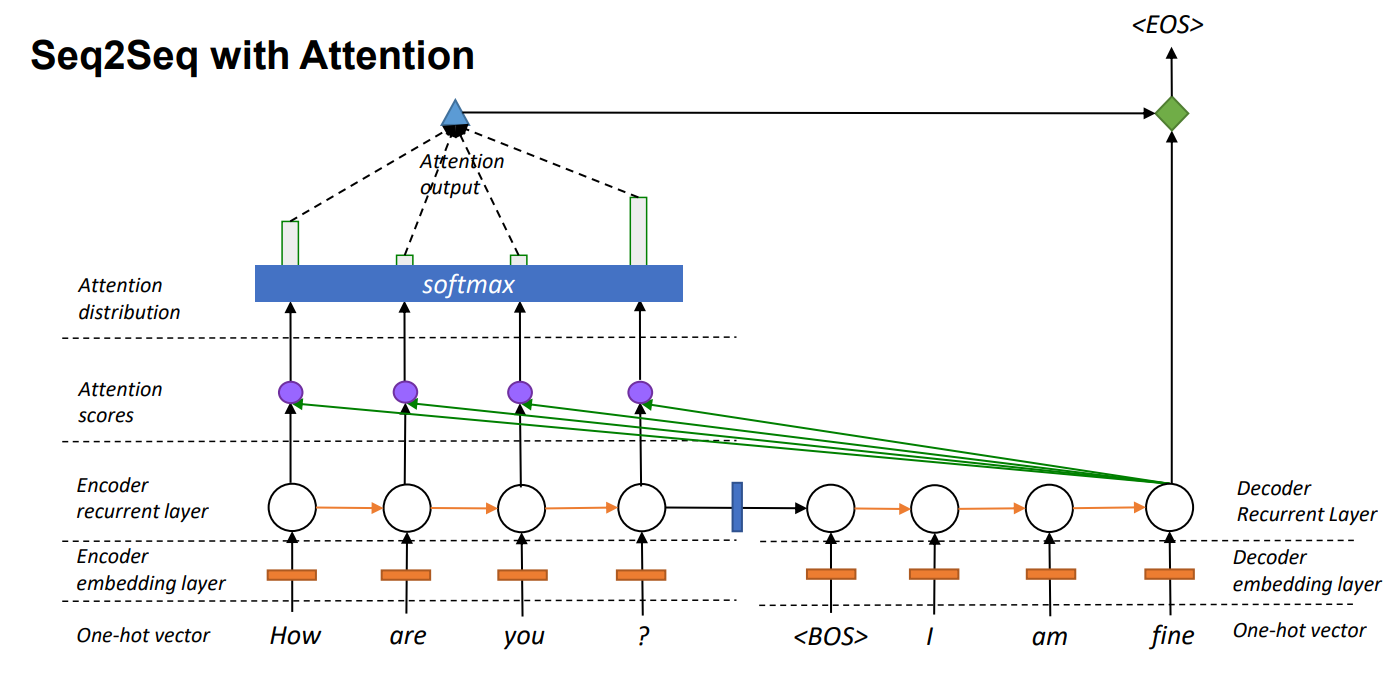


In [22]:
import torch
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 3.1 Encoder


In [23]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = embedding
        # Here we use GRU (https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
        # you can easily replace it with other RNN-based variants such as the valina RNN or LSTM
        # self.rnn = nn.RNN(self.hidden_size, self.hidden_size, bidirectional=True)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, bidirectional=True)
        # self.gru = nn.GRU(hidden_size, hidden_size, bidirectional=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        # output, hidden = self.rnn(embedded, hidden)
        output, hidden = self.lstm(embedded, hidden)
        # output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        # return torch.zeros(1, 1, self.hidden_size, device=device)
        # return torch.zeros(2, 1, self.hidden_size, device=device)
        return (
            torch.zeros(2, 1, self.hidden_size, device=device),  # For lstm
            torch.zeros(2, 1, self.hidden_size, device=device),
        )

## 3.2 Decoder


In [24]:
class AttnDecoderRNN(nn.Module):
    ATTN_TYPE_DOT_PRODUCT = "Dot Product"
    # We will practise the scaled dot product attention in the exercise
    ATTN_TYPE_SCALE_DOT_PRODUCT = "Scale Dot Product"

    def __init__(
        self, hidden_size, output_size, embedding, dropout_p=0.1, max_length=MAX_LENGTH
    ):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = embedding
        self.dropout = nn.Dropout(self.dropout_p)
        # self.rnn = nn.RNN(self.hidden_size, self.hidden_size, bidirectional=True)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, bidirectional=True)
        # self.gru = nn.GRU(self.hidden_size, self.hidden_size, bidirectional=True)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def cal_attention(self, hidden, encoder_hiddens, method):
        if method == AttnDecoderRNN.ATTN_TYPE_DOT_PRODUCT:
            # bmm: https://pytorch.org/docs/master/generated/torch.bmm.html
            # attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)),dim=-1)
            # attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
            # batched = torch.bmm(hidden, encoder_hiddens.T.repeat(2, 1, 1))
            # attn_weights = F.softmax(batched, dim=-1)
            # attn_output = torch.bmm(attn_weights, encoder_hiddens.repeat(2, 1, 1))
            # concat_output = torch.cat((attn_output[0], hidden[0]), 1)
            # For LSTM
            batched = torch.bmm(hidden[0], encoder_hiddens.T.repeat(2, 1, 1))
            attn_weights = F.softmax(batched, dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.repeat(2, 1, 1))
            concat_output = torch.cat((attn_output[0], hidden[0][0]), 1)

        return concat_output

    def forward(self, input, hidden, encoder_hiddens):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # _, hidden = self.rnn(embedded, hidden)
        _, hidden = self.lstm(embedded, hidden)
        # _, hidden = self.gru(embedded, hidden)

        concat_output = self.cal_attention(
            hidden, encoder_hiddens, AttnDecoderRNN.ATTN_TYPE_DOT_PRODUCT
        )

        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden

    def initHidden(self):
        # return torch.zeros(1, 1, self.hidden_size, device=device)
        # return torch.zeros(2, 1, self.hidden_size, device=device)
        return (
            torch.zeros(2, 1, self.hidden_size, device=device),  # For lstm
            torch.zeros(2, 1, self.hidden_size, device=device),
        )

## 3.3 Train Function


In [247]:
def train(
    input_tensor,
    target_tensor,
    encoder,
    decoder,
    encoder_optimizer,
    decoder_optimizer,
    criterion,
    nn_type="rnn",
    max_length=MAX_LENGTH,
):
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # it is for storing the hidden states of input sequence later, which will be used for calculating the attention during the decoding process
    encoder_hiddens = torch.zeros(max_length, encoder.hidden_size, device=device)

    # zero-initialize an initial hidden state
    encoder_hidden = encoder.initHidden()
    loss = 0
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Feed the input_tensor into the encoder we defined
    for i in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)
        encoder_hiddens[i] = (
            encoder_hidden[0][0, 0] if nn_type == "lstm" else encoder_hidden[0, 0]
        )

    # Use the <BOS> as the first token into decoder for generation
    decoder_input = torch.tensor([[word_to_ix["<BOS>"]]], device=device)

    decoder_hidden = encoder_hidden

    # Teacher forcing: Feed the target as the next input
    for i in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden, encoder_hiddens
        )
        loss += criterion(decoder_output, target_tensor[i])
        decoder_input = target_tensor[i]

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

## 3.4 Train Iterations Function


In [27]:
import time
import math


# Helper functions for training
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (- %s)" % (asMinutes(s), asMinutes(rs))

In [248]:
import random


def trainIters(
    encoder,
    decoder,
    n_iters,
    print_every=1000,
    plot_every=100,
    learning_rate=0.01,
    nn_type="rnn",
):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        random_choice_ix = random.choice(
            range(n_data)
        )  # Get a random index within the scope of input data
        input_index_r = [[ind] for ind in input_index[random_choice_ix]]
        target_index_r = [[ind] for ind in target_index[random_choice_ix]]

        input_tensor = torch.LongTensor(input_index_r).to(device)
        target_tensor = torch.LongTensor(target_index_r).to(device)

        loss = train(
            input_tensor,
            target_tensor,
            encoder,
            decoder,
            encoder_optimizer,
            decoder_optimizer,
            criterion,
            nn_type,
        )
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(
                "%s (%d %d%%) %.4f"
                % (
                    timeSince(start, iter / n_iters),
                    iter,
                    iter / n_iters * 100,
                    print_loss_avg,
                )
            )

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

# 4. Training Process


In [29]:
hidden_size = 50
embedding = nn.Embedding(len(word_to_ix), hidden_size)
encoder1 = EncoderRNN(hidden_size, embedding).to(device)
attn_decoder1 = AttnDecoderRNN(
    hidden_size, len(word_to_ix), embedding, dropout_p=0.1
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500)

0m 16s (- 5m 21s) (500 5%) 6.3238
0m 31s (- 4m 45s) (1000 10%) 4.5789
0m 46s (- 4m 26s) (1500 15%) 3.7088
1m 1s (- 4m 7s) (2000 20%) 3.1056
1m 17s (- 3m 53s) (2500 25%) 2.5933
1m 33s (- 3m 39s) (3000 30%) 2.2117
1m 50s (- 3m 25s) (3500 35%) 1.9147
2m 6s (- 3m 9s) (4000 40%) 1.6343
2m 22s (- 2m 54s) (4500 45%) 1.5298
2m 38s (- 2m 38s) (5000 50%) 1.4429
2m 54s (- 2m 22s) (5500 55%) 1.3055
3m 13s (- 2m 8s) (6000 60%) 1.1980
3m 33s (- 1m 54s) (6500 65%) 1.0611
3m 49s (- 1m 38s) (7000 70%) 1.0452
4m 5s (- 1m 21s) (7500 75%) 0.8992
4m 24s (- 1m 6s) (8000 80%) 0.8934
4m 43s (- 0m 50s) (8500 85%) 0.8213
5m 1s (- 0m 33s) (9000 90%) 0.8640
5m 21s (- 0m 16s) (9500 95%) 0.7870
5m 40s (- 0m 0s) (10000 100%) 0.7298


# 5. Evaluation


In [30]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_sent = pre_process([sentence])[0]
        intput_index = [word_to_ix[word] for word in input_sent]
        input_tensor = torch.LongTensor([[ind] for ind in intput_index]).to(device)

        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_hiddens = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            # encoder_hiddens[ei] += encoder_hidden[0, 0]
            encoder_hiddens[ei] = encoder_hidden[0][0, 0]  # LSTM

        decoder_input = torch.tensor([[word_to_ix["<BOS>"]]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_hiddens
            )
            topv, topi = decoder_output.data.topk(
                1
            )  # simply adopt the predicted tag with the highest probabiity
            if (
                topi.item() == word_to_ix["<EOS>"]
            ):  # if <EOS> is generated, stop the generation
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(
                    word_list[topi.item()]
                )  # get the predicted word based on the index
            # use the predicted output as the input for the next time step generation
            decoder_input = topi.squeeze().detach()

        return decoded_words

In [31]:
sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print(evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))

['i', 'love', 'that', 'you', 'love', 'stuff', '<EOS>']
['i', 'love', 'that', 'you', 'love', 'stuff', '<EOS>']
['that', 'is', 'not', 'one', 'of', 'my', 'talents', '<EOS>']
['i', 'am', 'a', 'work', 'in', 'progress', '<EOS>']


# Lab 7 Exercise

Please complete the following **question E1** for Lab 7 and check with your Tutor (Lab Facilitator) in the lab.

**Submission Due**: Your Lab 8 (in Week 9)

**Submission Method**: Show your final code to your tutor during the Lab.


## E1. Dot Product Attention VS. Scaled Dot Product Attention (2 marks)

Provided below is the implementation of the **Dot Product** attention. Please go through and try to change the **Dot Product** attention into **Scaled Dot Product** attention. You can refer to their definitions:

**Dot Product:**

![Dot_Product](https://drive.google.com/uc?id=1QtBgCp53e_6A_vzaMFEo89GJbTxnXagJ)

**Scaled Dot Product:**

![Scaled_Dot_Product](https://drive.google.com/uc?id=1v6n9WChBVfy0mBG2yxK9MUvGKzVGCmOt)


In [32]:
import numpy as np


class AttnDecoderRNN(nn.Module):
    ATTN_TYPE_DOT_PRODUCT = "Dot Product"
    ATTN_TYPE_SCALE_DOT_PRODUCT = "Scale Dot Product"

    def __init__(
        self, hidden_size, output_size, embedding, dropout_p=0.1, max_length=MAX_LENGTH
    ):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = embedding
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, bidirectional=True)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def cal_attention(self, hidden, encoder_hiddens, method):
        hidden = hidden.view(hidden.shape[0], -1, 2 * self.hidden_size)
        # Dot Product Attention
        if method == AttnDecoderRNN.ATTN_TYPE_DOT_PRODUCT:
            # bmm: https://pytorch.org/docs/master/generated/torch.bmm.html
            # attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)),dim=-1)
            # attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
            attn_weights = F.softmax(
                torch.bmm(hidden, encoder_hiddens.T.repeat(2, 1, 1)), dim=-1
            )
            attn_output = torch.bmm(attn_weights, encoder_hiddens.repeat(2, 1, 1))
            concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        # Scaled Dot Product Attention
        elif method == AttnDecoderRNN.ATTN_TYPE_SCALE_DOT_PRODUCT:
            # [TODO] COMPLETE THIS PART - Scaled Dot Product calculation method
            # Hint: - Try to think about what the n is about in the equation
            #       - Then, all you need to do is to apply the scaling (devided by the square-root of n) to the original score of the Dot Product Attention, before applying the softmax
            #       - Considering using np.sqrt() from numpy for conducting the non-negative square-root function
            # attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0))/np.sqrt(self.hidden_size),dim=-1)
            # attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
            attn_weights = F.softmax(
                torch.bmm(hidden, encoder_hiddens.T.repeat(2, 1, 1))
                / np.sqrt(self.hidden_size),
                dim=-1,
            )
            attn_output = torch.bmm(attn_weights, encoder_hiddens.repeat(2, 1, 1))
            concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        return concat_output

    def forward(self, input, hidden, encoder_hiddens):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        _, hidden = self.gru(embedded, hidden)

        ## The following attention score calculation method is Dot Product for now
        ## It can be switched to Scaled Dot Product calculation method
        # concat_output = self.cal_attention(hidden, encoder_hiddens, AttnDecoderRNN.ATTN_TYPE_DOT_PRODUCT)
        concat_output = self.cal_attention(
            hidden, encoder_hiddens, AttnDecoderRNN.ATTN_TYPE_SCALE_DOT_PRODUCT
        )

        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden

    def initHidden(self):
        # return torch.zeros(1, 1, self.hidden_size, device=device)
        return torch.zeros(2, 1, self.hidden_size, device=device)

In [33]:
from enum import Enum


class NNType(Enum):
    RNN = "rnn"
    LSTM = "lstm"
    GRU = "gru"

    def __str__(self):
        return self.value

In [34]:
print(NNType.LSTM)

lstm


In [47]:
from typing import Literal, Dict, Type, Union


class NNType(Enum):
    RNN = "rnn"
    LSTM = "lstm"
    GRU = "gru"

    def __str__(self):
        return self.value


NN_MAP: Dict[NNType, int] = {
    NNType.RNN: 1,
    NNType.LSTM: 2,
    NNType.GRU: 3,
}


class AttentionMethod(Enum):
    DOT_PRODUCT = "dot_product"
    SCALE_DOT_PRODUCT = "scale_dot_product"
    COSINE_SIMILARITY = "cosine_similarity"

    def __str__(self):
        return self.value

In [48]:
print(AttentionMethod("cosine_similarity") == AttentionMethod.COSINE_SIMILARITY)

True


In [241]:
import torch
from torch import Tensor
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np

from typing import Literal, Dict, Type, Union
from enum import Enum

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class NNType(Enum):
    RNN = "rnn"
    LSTM = "lstm"
    GRU = "gru"

    def __str__(self):
        return self.value


NN_MAP: Dict[NNType, Type[Union[nn.RNN, nn.LSTM, nn.GRU]]] = {
    NNType.RNN: nn.RNN,
    NNType.LSTM: nn.LSTM,
    NNType.GRU: nn.GRU,
}


class AttentionMethod(Enum):
    DOT_PRODUCT = "dot_product"
    SCALE_DOT_PRODUCT = "scale_dot_product"
    COSINE_SIMILARITY = "cosine_similarity"

    def __str__(self):
        return self.value


class DecoderRNN(nn.Module):
    def __init__(
        self,
        hidden_size: int,
        output_size: int,
        embedding: nn.Embedding,
        max_length: int,
        nn_type: Literal["rnn", "lstm", "gru"] = "rnn",
        num_layers=1,
        dropout_p=0.1,
        attention_method: Literal[
            "dot_product",
            "scale_dot_product",
            "cosine_similarity",
        ] = "dot_product",
    ):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.embedding = embedding
        self.dropout = nn.Dropout(self.dropout_p)
        self.nn_type = NNType(nn_type)
        self.attention_method = AttentionMethod(attention_method)
        self.nn = NN_MAP[self.nn_type](
            hidden_size,
            hidden_size,
            num_layers=num_layers,
        )
        self.attn = nn.Linear(self.hidden_size * 2, 1)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def cal_attention(self, hidden: Tensor, encoder_hiddens: Tensor):
        if self.attention_method == AttentionMethod.DOT_PRODUCT:
            if self.nn_type == NNType.LSTM:  # For LSTM
                attn_weights = F.softmax(
                    torch.bmm(hidden[0], encoder_hiddens.T.unsqueeze(0)), dim=-1
                )
                attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
                concat_output = torch.cat((attn_output[0], hidden[0][0]), 1)
            else:  # For RNN & GRU
                attn_weights = F.softmax(
                    torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)), dim=-1
                )
                attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
                concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        elif self.attention_method == AttentionMethod.COSINE_SIMILARITY:
            if self.nn_type == NNType.LSTM:  # For LSTM
                cosine_similarity = nn.CosineSimilarity(dim=-1)
                attn_weights = F.softmax(
                    cosine_similarity(hidden[0], encoder_hiddens), dim=-1
                )
                attn_output = torch.bmm(
                    attn_weights.unsqueeze(0), encoder_hiddens.unsqueeze(0)
                )
                concat_output = torch.cat((attn_output[0], hidden[0][0]), 1)
            else:  # For RNN & GRU
                cosine_similarity = nn.CosineSimilarity(dim=-1)
                attn_weights = F.softmax(
                    cosine_similarity(hidden, encoder_hiddens), dim=-1
                )
                attn_output = torch.bmm(
                    attn_weights.unsqueeze(0), encoder_hiddens.unsqueeze(0)
                )
                concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        # For scale dot product
        elif self.nn_type == NNType.LSTM:  # For LSTM
            energy = torch.bmm(hidden[0], encoder_hiddens.T.unsqueeze(0)) / np.sqrt(
                self.hidden_size
            )
            attn_weights = F.softmax(energy, dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
            concat_output = torch.cat((attn_output[0], hidden[0][0]), 1)

        else:  # For RNN & GRU
            attn_weights = F.softmax(
                torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0))
                / np.sqrt(self.hidden_size),
                dim=-1,
            )
            attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
            concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        return concat_output

    def forward(self, input: nn.Embedding, hidden: Tensor, encoder_hiddens: Tensor):
        embedded: Tensor = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        _, hidden = self.nn(embedded, hidden)
        concat_output = self.cal_attention(hidden, encoder_hiddens)
        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden

    def initHidden(self):
        return (
            torch.zeros(1, 1, self.hidden_size, device=device)
            if self.nn_type != NNType.LSTM
            else (
                torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device),
            )
        )

In [255]:
from token import DOT
from unicodedata import bidirectional
import torch
from torch import Tensor
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np

from typing import Literal, Dict, Type, Union
from enum import Enum

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class NNType(Enum):
    RNN = "rnn"
    LSTM = "lstm"
    GRU = "gru"

    def __str__(self):
        return self.value


NN_MAP: Dict[NNType, Type[Union[nn.RNN, nn.LSTM, nn.GRU]]] = {
    NNType.RNN: nn.RNN,
    NNType.LSTM: nn.LSTM,
    NNType.GRU: nn.GRU,
}


class AttentionMethod(Enum):
    DOT_PRODUCT = "dot_product"
    SCALE_DOT_PRODUCT = "scale_dot_product"
    COSINE_SIMILARITY = "cosine_similarity"

    def __str__(self):
        return self.value


class DecoderBiRNN(nn.Module):
    def __init__(
        self,
        hidden_size: int,
        output_size: int,
        embedding: nn.Embedding,
        max_length: int,
        nn_type: Literal["rnn", "lstm", "gru"] = "rnn",
        num_layers=1,
        dropout_p=0.1,
        attention_method: Literal[
            "dot_product",
            "scale_dot_product",
            "cosine_similarity",
        ] = "dot_product",
    ):
        super(DecoderBiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.embedding = embedding
        self.dropout = nn.Dropout(self.dropout_p)
        self.nn_type = NNType(nn_type)
        self.attention_method = AttentionMethod(attention_method)
        self.nn = NN_MAP[self.nn_type](
            hidden_size,
            hidden_size,
            num_layers=num_layers,
            bidirectional=True,
        )
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def cal_attention(self, hidden: Tensor, encoder_hiddens: Tensor):
        if self.attention_method == AttentionMethod.DOT_PRODUCT:
            if self.nn_type == NNType.LSTM:  # For BiLSTM
                energy = torch.bmm(hidden[0], encoder_hiddens.T.repeat(2, 1, 1))
                attn_weights = F.softmax(energy, dim=-1)
                attn_output = torch.bmm(attn_weights, encoder_hiddens.repeat(2, 1, 1))
                concat_output = torch.cat((attn_output[0], hidden[0][0]), 1)
            else:  # For BiRNN & BiGRU
                energy = torch.bmm(hidden, encoder_hiddens.T.repeat(2, 1, 1))
                attn_weights = F.softmax(energy, dim=-1)
                attn_output = torch.bmm(attn_weights, encoder_hiddens.repeat(2, 1, 1))
                concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        elif self.attention_method == AttentionMethod.COSINE_SIMILARITY:
            if self.nn_type == NNType.LSTM:  # For LSTM
                cosine_similarity = nn.CosineSimilarity(dim=-1)
                h_n, c_n = hidden
                h_n_reshaped = h_n.mean(dim=0, keepdim=True)
                attn_weights = F.softmax(
                    cosine_similarity(h_n_reshaped, encoder_hiddens), dim=-1
                )
                attn_output = torch.bmm(
                    attn_weights.unsqueeze(0), encoder_hiddens.unsqueeze(0)
                )
                concat_output = torch.cat((attn_output[0], h_n_reshaped[0]), 1)

            else:  # For RNN & GRU
                cosine_similarity = nn.CosineSimilarity(dim=-1)
                hidden_reshaped = hidden.mean(dim=0, keepdim=True)
                attn_weights = F.softmax(
                    cosine_similarity(hidden_reshaped, encoder_hiddens), dim=-1
                )
                attn_output = torch.bmm(
                    attn_weights.unsqueeze(0), encoder_hiddens.unsqueeze(0)
                )
                concat_output = torch.cat((attn_output[0], hidden_reshaped[0]), 1)
        else:
            if self.nn_type == NNType.LSTM:  # For LSTM
                energy = torch.bmm(
                    hidden[0], encoder_hiddens.T.repeat(2, 1, 1)
                ) / np.sqrt(self.hidden_size)
                attn_weights = F.softmax(energy, dim=-1)
                attn_output = torch.bmm(attn_weights, encoder_hiddens.repeat(2, 1, 1))
                concat_output = torch.cat((attn_output[0], hidden[0][0]), 1)
            else:  # For RNN & GRU
                energy = torch.bmm(hidden, encoder_hiddens.T.repeat(2, 1, 1)) / np.sqrt(
                    self.hidden_size
                )
                attn_weights = F.softmax(energy, dim=-1)
                attn_output = torch.bmm(attn_weights, encoder_hiddens.repeat(2, 1, 1))
                concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        return concat_output

    def forward(self, input: nn.Embedding, hidden: Tensor, encoder_hiddens: Tensor):
        embedded: Tensor = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        _, hidden = self.nn(embedded, hidden)
        concat_output = self.cal_attention(hidden, encoder_hiddens)
        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden

    def initHidden(self):
        return (
            torch.zeros(2, 1, self.hidden_size, device=device)
            if self.nn_type != NNType.LSTM
            else (
                torch.zeros(2, 1, self.hidden_size, device=device),
                torch.zeros(2, 1, self.hidden_size, device=device),
            )
        )

In [218]:
from neural_network import EncoderRNN, EncoderBiRNN

In [258]:
hidden_size = 50
embedding = nn.Embedding(len(word_to_ix), hidden_size)
nn_type = "rnn"
# nn_type = "lstm"
# nn_type = "gru"
encoder1 = EncoderBiRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderBiRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    attention_method="dot_product",
    # attention_method="cosine_similarity",
    # attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

encoder1 = EncoderBiRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderBiRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    # attention_method="dot_product",
    attention_method="cosine_similarity",
    # attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

encoder1 = EncoderBiRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderBiRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    # attention_method="dot_product",
    # attention_method="cosine_similarity",
    attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

0m 20s (- 6m 21s) (500 5%) 4.8969
0m 36s (- 5m 31s) (1000 10%) 2.9480
0m 55s (- 5m 12s) (1500 15%) 2.1708
1m 15s (- 5m 3s) (2000 20%) 1.7060
1m 31s (- 4m 35s) (2500 25%) 1.5159
1m 50s (- 4m 18s) (3000 30%) 1.3145
2m 10s (- 4m 1s) (3500 35%) 1.1481
2m 27s (- 3m 41s) (4000 40%) 1.0854
2m 43s (- 3m 19s) (4500 45%) 0.9703
2m 58s (- 2m 58s) (5000 50%) 0.9069
3m 14s (- 2m 38s) (5500 55%) 0.8619
3m 31s (- 2m 21s) (6000 60%) 0.8567
3m 47s (- 2m 2s) (6500 65%) 0.8040
4m 3s (- 1m 44s) (7000 70%) 0.7514
4m 18s (- 1m 26s) (7500 75%) 0.7427
4m 34s (- 1m 8s) (8000 80%) 0.6984
4m 50s (- 0m 51s) (8500 85%) 0.7091
5m 9s (- 0m 34s) (9000 90%) 0.7392
5m 25s (- 0m 17s) (9500 95%) 0.6272
5m 43s (- 0m 0s) (10000 100%) 0.6108

i like you lots <EOS>
that is not one of my talents <EOS>
that is not one of my talents <EOS>
that is not one of my talents <EOS>

0m 21s (- 6m 57s) (500 5%) 5.3699
0m 43s (- 6m 29s) (1000 10%) 3.4763
1m 4s (- 6m 5s) (1500 15%) 2.7628
1m 26s (- 5m 44s) (2000 20%) 2.3022
1m 47s (- 5m 21

In [259]:
hidden_size = 50
embedding = nn.Embedding(len(word_to_ix), hidden_size)
# nn_type = "rnn"
nn_type = "lstm"
# nn_type = "gru"
encoder1 = EncoderBiRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderBiRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    attention_method="dot_product",
    # attention_method="cosine_similarity",
    # attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

encoder1 = EncoderBiRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderBiRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    # attention_method="dot_product",
    attention_method="cosine_similarity",
    # attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

encoder1 = EncoderBiRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderBiRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    # attention_method="dot_product",
    # attention_method="cosine_similarity",
    attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

0m 17s (- 5m 28s) (500 5%) 6.3623
0m 35s (- 5m 16s) (1000 10%) 4.5152
0m 52s (- 4m 55s) (1500 15%) 3.7277
1m 9s (- 4m 36s) (2000 20%) 3.1155
1m 25s (- 4m 17s) (2500 25%) 2.5316
1m 43s (- 4m 1s) (3000 30%) 2.2154
2m 0s (- 3m 43s) (3500 35%) 1.9105
2m 17s (- 3m 26s) (4000 40%) 1.7253
2m 35s (- 3m 9s) (4500 45%) 1.4791
2m 51s (- 2m 51s) (5000 50%) 1.4411
3m 7s (- 2m 33s) (5500 55%) 1.2053
3m 25s (- 2m 16s) (6000 60%) 1.1766
3m 41s (- 1m 59s) (6500 65%) 1.1083
3m 57s (- 1m 41s) (7000 70%) 1.0928
4m 14s (- 1m 24s) (7500 75%) 0.9869
4m 32s (- 1m 8s) (8000 80%) 0.8903
4m 48s (- 0m 50s) (8500 85%) 0.8912
5m 4s (- 0m 33s) (9000 90%) 0.8313
5m 22s (- 0m 16s) (9500 95%) 0.7826
5m 38s (- 0m 0s) (10000 100%) 0.7876

you are pretty neat <EOS>
i only do food for thought <EOS>
no way <EOS>
i am a work in progress <EOS>

0m 22s (- 6m 59s) (500 5%) 6.7425
0m 46s (- 6m 57s) (1000 10%) 4.9647
1m 8s (- 6m 28s) (1500 15%) 4.2051
1m 30s (- 6m 2s) (2000 20%) 3.6972
1m 51s (- 5m 33s) (2500 25%) 3.1405
2m 11s (

In [260]:
hidden_size = 50
embedding = nn.Embedding(len(word_to_ix), hidden_size)
# nn_type = "rnn"
# nn_type = "lstm"
nn_type = "gru"
encoder1 = EncoderBiRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderBiRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    attention_method="dot_product",
    # attention_method="cosine_similarity",
    # attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

encoder1 = EncoderBiRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderBiRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    # attention_method="dot_product",
    attention_method="cosine_similarity",
    # attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

encoder1 = EncoderBiRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderBiRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    # attention_method="dot_product",
    # attention_method="cosine_similarity",
    attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

0m 16s (- 5m 22s) (500 5%) 5.5177
0m 37s (- 5m 37s) (1000 10%) 3.6130
0m 54s (- 5m 11s) (1500 15%) 2.8688
1m 12s (- 4m 51s) (2000 20%) 2.1615
1m 29s (- 4m 29s) (2500 25%) 1.7470
1m 48s (- 4m 13s) (3000 30%) 1.6289
2m 5s (- 3m 53s) (3500 35%) 1.5415
2m 23s (- 3m 34s) (4000 40%) 1.2530
2m 40s (- 3m 16s) (4500 45%) 1.1430
2m 58s (- 2m 58s) (5000 50%) 1.0363
3m 15s (- 2m 40s) (5500 55%) 0.9411
3m 32s (- 2m 21s) (6000 60%) 0.8665
3m 49s (- 2m 3s) (6500 65%) 0.8777
4m 7s (- 1m 46s) (7000 70%) 0.8178
4m 26s (- 1m 28s) (7500 75%) 0.7422
4m 43s (- 1m 10s) (8000 80%) 0.7226
4m 59s (- 0m 52s) (8500 85%) 0.6722
5m 17s (- 0m 35s) (9000 90%) 0.6743
5m 34s (- 0m 17s) (9500 95%) 0.6581
5m 52s (- 0m 0s) (10000 100%) 0.6217

chat away <EOS>
hi <EOS>
chat away <EOS>
i am a work in progress <EOS>

0m 21s (- 6m 44s) (500 5%) 5.9246
0m 42s (- 6m 20s) (1000 10%) 4.0343
1m 3s (- 6m 1s) (1500 15%) 3.3932
1m 25s (- 5m 41s) (2000 20%) 2.7984
1m 47s (- 5m 21s) (2500 25%) 2.4342
2m 8s (- 4m 59s) (3000 30%) 2.0723


In [261]:
hidden_size = 50
embedding = nn.Embedding(len(word_to_ix), hidden_size)
nn_type = "rnn"
# nn_type = "lstm"
# nn_type = "gru"
encoder1 = EncoderRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    attention_method="dot_product",
    # attention_method="cosine_similarity",
    # attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

encoder1 = EncoderRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    # attention_method="dot_product",
    attention_method="cosine_similarity",
    # attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

encoder1 = EncoderRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    # attention_method="dot_product",
    # attention_method="cosine_similarity",
    attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

0m 13s (- 4m 25s) (500 5%) 4.8049
0m 28s (- 4m 15s) (1000 10%) 2.9769
0m 44s (- 4m 10s) (1500 15%) 2.2613
0m 57s (- 3m 50s) (2000 20%) 1.7991
1m 11s (- 3m 35s) (2500 25%) 1.5437
1m 26s (- 3m 21s) (3000 30%) 1.2937
1m 41s (- 3m 8s) (3500 35%) 1.2538
1m 55s (- 2m 52s) (4000 40%) 1.0616
2m 8s (- 2m 36s) (4500 45%) 1.0598
2m 22s (- 2m 22s) (5000 50%) 0.9906
2m 34s (- 2m 6s) (5500 55%) 0.9484
2m 48s (- 1m 52s) (6000 60%) 0.8330
3m 2s (- 1m 38s) (6500 65%) 0.8305
3m 21s (- 1m 26s) (7000 70%) 0.8236
3m 38s (- 1m 12s) (7500 75%) 0.7786
3m 54s (- 0m 58s) (8000 80%) 0.7460
4m 8s (- 0m 43s) (8500 85%) 0.7609
4m 26s (- 0m 29s) (9000 90%) 0.6875
4m 40s (- 0m 14s) (9500 95%) 0.6680
4m 54s (- 0m 0s) (10000 100%) 0.6911

you are all trying to make life a virtual hug right now <EOS>
cool <EOS>
i am a bot who was created by humans <EOS>
i am a bot who was created by humans <EOS>

0m 21s (- 6m 54s) (500 5%) 5.0580
0m 41s (- 6m 15s) (1000 10%) 3.0746
1m 2s (- 5m 56s) (1500 15%) 2.3710
1m 25s (- 5m 43s) (2

In [262]:
hidden_size = 50
embedding = nn.Embedding(len(word_to_ix), hidden_size)
# nn_type = "rnn"
nn_type = "lstm"
# nn_type = "gru"
encoder1 = EncoderRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    attention_method="dot_product",
    # attention_method="cosine_similarity",
    # attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

encoder1 = EncoderRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    # attention_method="dot_product",
    attention_method="cosine_similarity",
    # attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

encoder1 = EncoderRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    # attention_method="dot_product",
    # attention_method="cosine_similarity",
    attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

0m 14s (- 4m 26s) (500 5%) 6.4553
0m 27s (- 4m 10s) (1000 10%) 4.5940
0m 41s (- 3m 53s) (1500 15%) 3.7324
0m 57s (- 3m 48s) (2000 20%) 3.2500
1m 11s (- 3m 33s) (2500 25%) 2.7100
1m 25s (- 3m 18s) (3000 30%) 2.2358
1m 40s (- 3m 6s) (3500 35%) 2.0838
1m 54s (- 2m 52s) (4000 40%) 1.7361
2m 7s (- 2m 36s) (4500 45%) 1.5955
2m 23s (- 2m 23s) (5000 50%) 1.4242
2m 37s (- 2m 8s) (5500 55%) 1.3654
2m 51s (- 1m 54s) (6000 60%) 1.1457
3m 5s (- 1m 39s) (6500 65%) 1.0986
3m 21s (- 1m 26s) (7000 70%) 1.0519
3m 34s (- 1m 11s) (7500 75%) 0.9815
3m 48s (- 0m 57s) (8000 80%) 0.9084
4m 4s (- 0m 43s) (8500 85%) 0.8774
4m 19s (- 0m 28s) (9000 90%) 0.7978
4m 32s (- 0m 14s) (9500 95%) 0.7884
4m 49s (- 0m 0s) (10000 100%) 0.7146

you are pretty neat <EOS>
i am a work in progress <EOS>
i am a work in progress <EOS>
i am a work in progress <EOS>

0m 19s (- 6m 16s) (500 5%) 6.1738
0m 38s (- 5m 49s) (1000 10%) 4.3888
0m 59s (- 5m 36s) (1500 15%) 3.5820
1m 17s (- 5m 10s) (2000 20%) 3.0430
1m 37s (- 4m 53s) (2500 25

In [263]:
hidden_size = 50
embedding = nn.Embedding(len(word_to_ix), hidden_size)
# nn_type = "rnn"
# nn_type = "lstm"
nn_type = "gru"
encoder1 = EncoderRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    attention_method="dot_product",
    # attention_method="cosine_similarity",
    # attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

encoder1 = EncoderRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    # attention_method="dot_product",
    attention_method="cosine_similarity",
    # attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

encoder1 = EncoderRNN(hidden_size, embedding, nn_type).to(device)
attn_decoder1 = DecoderRNN(
    hidden_size,
    len(word_to_ix),
    embedding,
    max_length=MAX_LENGTH,
    nn_type=nn_type,
    dropout_p=0.1,
    # attention_method="dot_product",
    # attention_method="cosine_similarity",
    attention_method="scale_dot_product",
).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500, nn_type=nn_type)

sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print()
print(*evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(*evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))
print()

0m 14s (- 4m 34s) (500 5%) 5.5485
0m 30s (- 4m 35s) (1000 10%) 3.7366
0m 44s (- 4m 10s) (1500 15%) 2.8226
0m 58s (- 3m 55s) (2000 20%) 2.2088
1m 13s (- 3m 41s) (2500 25%) 1.8595
1m 28s (- 3m 26s) (3000 30%) 1.5896
1m 42s (- 3m 10s) (3500 35%) 1.4130
1m 58s (- 2m 57s) (4000 40%) 1.2715
2m 12s (- 2m 41s) (4500 45%) 1.1204
2m 26s (- 2m 26s) (5000 50%) 1.0768
2m 40s (- 2m 11s) (5500 55%) 0.9897
2m 56s (- 1m 57s) (6000 60%) 0.9301
3m 11s (- 1m 42s) (6500 65%) 0.8386
3m 26s (- 1m 28s) (7000 70%) 0.7791
3m 39s (- 1m 13s) (7500 75%) 0.7942
3m 54s (- 0m 58s) (8000 80%) 0.7257
4m 8s (- 0m 43s) (8500 85%) 0.6875
4m 24s (- 0m 29s) (9000 90%) 0.6832
4m 39s (- 0m 14s) (9500 95%) 0.6098
4m 53s (- 0m 0s) (10000 100%) 0.6006

you are happy <EOS>
you are happy <EOS>
i am a work in progress <EOS>
i am a work in progress <EOS>

0m 20s (- 6m 25s) (500 5%) 5.4198
0m 38s (- 5m 49s) (1000 10%) 3.5755
0m 58s (- 5m 31s) (1500 15%) 2.8274
1m 18s (- 5m 15s) (2000 20%) 2.4564
1m 37s (- 4m 51s) (2500 25%) 2.0462
1m

In [ ]:
import optuna


def objective(trial):
    # Define the hyperparameters to search over
    encoder_num_layers = trial.suggest_int("encoder_num_layers", 1, 2)
    decoder_num_layers = trial.suggest_int("decoder_num_layers", 1, 2)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)

    nn_type = trial.suggest_categorical("nn_type", ["rnn", "lstm", "gru"])

    # Train the model with the given hyperparameters
    encoder1 = EncoderRNN(
        hidden_size, embedding, nn_type=nn_type, num_layers=encoder_num_layers
    ).to(device)
    decoder1 = DecoderRNN(
        hidden_size,
        len(word_to_ix),
        embedding,
        max_length=MAX_LENGTH,
        nn_type=nn_type,
        num_layers=decoder_num_layers,
        dropout_p=0.1,
        attention_method="dot_product",
    ).to(device)
    trainIters(
        encoder1,
        decoder1,
        10000,
        learning_rate=learning_rate,
        print_every=0,
        nn_type=nn_type,
    )

    # Evaluate the model on a validation set and return the performance metric
    precision, accuracy, recall, f1 = evaluate(encoder1, decoder1, X_val, y_val)
    return f1


# Create a study object and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)